In [1]:
# Import libraries
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.display.max_columns = None

In [2]:
# Read metadata and merge pre_biopsy data
metadata=pd.read_csv('data/metadata_update.tsv',sep="\t", header=0)
pre_biopsy=pd.read_csv('data/pre_biopsy_drugs_update.tsv',sep="\t", header=0)
metadata['patientIdentifier'] = metadata['sampleId'].str[:12]
df_survival=pd.merge(pre_biopsy, metadata, on='patientIdentifier')
df_survival=df_survival[df_survival['biopsyDate'].isnull()==False] #delete all that dont have a given biopsyDate
df_survival=df_survival[['sampleId','hasSystemicPreTreatment','hasRadiotherapyPreTreatment','biopsySite', 'startDate','biopsyDate','birthYear','consolidatedTreatmentType','primaryTumorLocation','gender','type','deathDate', 'primaryTumorSubType','tumorPurity', 'treatmentEndDate']]
df_survival['status'] = 1 # set status as dead
df_survival['deathDate'] = df_survival['deathDate'].fillna(0) # If donor is still alive
df_survival['status'][df_survival['deathDate']==0] = 0 # set alive donors as alive

# Calculating survival times
'''
Assumption: If there is not death reported, we will asume that the donor is still alive at the date of the last update of the metadata.
'''

df_survival['biopsyDate'] = pd.to_datetime(df_survival['biopsyDate'])

## OS (Overall Survival): Death date - Biopsy date
### Dead donors
df_survival['deathDate'] = pd.to_datetime(df_survival['deathDate'], errors='coerce')
mask = df_survival['status']==1
df_survival.loc[mask, 'OS_time'] = (df_survival['deathDate'] - df_survival['biopsyDate']).dt.days
### Alive donors
last_update = pd.to_datetime('2023-04-04') # If there is not deathDate, I substract it by the last documented update
mask = pd.notnull(df_survival['startDate']) & (df_survival['status'] == 0) 
df_survival.loc[mask, 'OS_time'] = (last_update - df_survival['biopsyDate']).dt.days

df_survival = df_survival[df_survival['OS_time']>0.0]

## PFI (Progression-free interval): treatmentEndDate - Biopsy date
## If treatment ended
df_survival['treatmentEndDate'] = pd.to_datetime(df_survival['treatmentEndDate'])
mask = pd.notnull(df_survival['treatmentEndDate'])
df_survival.loc[mask, 'PFI_time'] = (df_survival['treatmentEndDate'] - df_survival['biopsyDate']).dt.days
### If treatment is still ongoing
mask = pd.isnull(df_survival['treatmentEndDate'])
df_survival.loc[mask, 'PFI_time'] = (last_update - df_survival['biopsyDate']).dt.days

df_survival = df_survival[df_survival['PFI_time']>0]

df_survival = df_survival.drop_duplicates(subset='sampleId', keep="first")
df_survival

/tmp/ipykernel_925488/3247299246.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_survival['status'][df_survival['deathDate']==0] = 0 # set alive donors as alive
/tmp/ipykernel_925488/3247299246.py:10: SettingWithCopyWarning: 
A value

,sampleId,hasSystemicPreTreatment,hasRadiotherapyPreTreatment,biopsySite,startDate,biopsyDate,birthYear,consolidatedTreatmentType,primaryTumorLocation,gender,type,deathDate,primaryTumorSubType,tumorPurity,treatmentEndDate,status,OS_time,PFI_time
0,CPCT02010003T,Yes,Yes,Liver,2009-12-14,2012-04-18,1955.0,Chemotherapy,Breast,female,Hormonal therapy,2013-01-29,ER-positive/HER2-negative,0.40,2012-10-01,1,286.0,166.0
4,CPCT02010022T,Yes,Yes,Liver,2011-04-01,2012-07-10,1952.0,Chemotherapy,Lung,male,Chemotherapy,2014-04-14,Non-small cell carcinoma,0.45,2012-11-26,1,643.0,139.0
6,CPCT02010037T,Yes,Yes,Skin,2012-06-01,2012-08-06,1958.0,Chemotherapy,Lung,male,Chemotherapy,2012-12-06,Non-small cell carcinoma,0.56,2012-08-29,1,122.0,23.0
8,CPCT02010050T,Yes,No,Lung,2011-12-20,2012-09-17,1946.0,Chemotherapy,Lung,female,Chemotherapy,2013-01-21,Non-small cell carcinoma,0.37,2012-11-07,1,126.0,51.0
11,CPCT02010063T,Yes,Yes,Left mamma,2010-04-30,2012-10-26,1974.0,Multiple therapy,Lung,female,Chemotherapy,2015-03-14,Non-small cell carcinoma,0.91,2012-12-11,1,869.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10014,CPCT02460004T,Yes,No,Liver,2016-02-11,2018-11-01,1966.0,Multiple therapy,Breast,female,Targeted therapy,NaT,ER-positive/HER2-positive,0.54,NaT,0,1615.0,1615.0
10018,CPCT02460005T,Yes,Yes,Liver,2017-07-31,2019-01-02,1988.0,Chemotherapy,Breast,female,Chemotherapy,2019-06-04,Triple negative,0.92,2019-05-06,1,153.0,124.0
10021,CPCT02460006T,Yes,Yes,Liver,2009-06-01,2019-01-31,1968.0,Chemotherapy,Breast,female,Chemotherapy,2019-03-23,ER-positive/HER2-negative,0.66,2019-03-23,1,51.0,51.0
10034,CPCT02470001T,Yes,Yes,Liver,2014-10-13,2018-12-07,1931.0,NaN,Breast,female,Hormonal therapy,2019-12-26,ER-positive/HER2-negative,0.38,NaT,1,384.0,1579.0


In [3]:
df_out = pd.read_csv('../../results/all_HMF.csv', sep=",", header=0)
# if score_WF < score_EXP, mode is WF otherwise EXP
df_out['class'] = np.where(df_out['score_WF'] < df_out['score_EXP'], 'WF', 'EXP')
df_out['sampleId'] = df_out['donor']
df_class = df_out[['sampleId', 'class']]
df_class

,sampleId,class
0,CPCT02340020T,EXP
1,CPCT02040278T,WF
2,DRUP01070024T,EXP
3,CPCT02020434T,WF
4,CPCT02020271T,WF
...,...,...
1442,CPCT02050291T,WF
1443,CPCT02130093T,EXP
1444,CPCT02040280T,WF
1445,CPCT02030529T,EXP


In [4]:
# Format the data
# Merge the prediction
df = pd.merge(df_survival, df_class, on='sampleId')
# Remove NA's
df = df.dropna(subset=['birthYear', 'gender', 'OS_time', 'PFI_time'])
# class: WF -> 0, EXP -> 1
df = df[df['class']!='CC']
df['class'] = df['class'].replace(to_replace='WF', value=0)
df['class'] = df['class'].replace(to_replace='EXP', value=1)
# Calculate age at diagnosis based on birthYear
df['year_of_diagnosis']=df['biopsyDate'].astype(str)
df['year_of_diagnosis'] = df['year_of_diagnosis'].str[:4]
df['year_of_diagnosis']=df['year_of_diagnosis'].astype(int)
df['birthYear']=df['birthYear'].astype(int)
df['age'] = (df['year_of_diagnosis']-df['birthYear']) # change to biopsy date. 
df['age']=df['age'].astype(int)
# # gender: female -> 0, male -> 1
df['gender'] = df['gender'].replace(to_replace='female', value=0)
df['gender'] = df['gender'].replace(to_replace='male', value=1)
# # Add vital state
# df['type'] = df['primaryTumorLocation'] + df['primaryTumorSubType']
# Filter by cancer type
# df = df[df['primaryTumorLocation']=='Stomach']
# print(pd.crosstab(index=df['class'], columns=df['type']))
# df = df[df['consolidatedTreatmentType']=='Immunotherapy']

df

/tmp/ipykernel_925488/3342163456.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace(to_replace='EXP', value=1)
/tmp/ipykernel_925488/3342163456.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(to_replace='male', value=1)


,sampleId,hasSystemicPreTreatment,hasRadiotherapyPreTreatment,biopsySite,startDate,biopsyDate,birthYear,consolidatedTreatmentType,primaryTumorLocation,gender,type,deathDate,primaryTumorSubType,tumorPurity,treatmentEndDate,status,OS_time,PFI_time,class,year_of_diagnosis,age
0,CPCT02010022T,Yes,Yes,Liver,2011-04-01,2012-07-10,1952,Chemotherapy,Lung,1,Chemotherapy,2014-04-14,Non-small cell carcinoma,0.45,2012-11-26,1,643.0,139.0,1,2012,60
1,CPCT02010037T,Yes,Yes,Skin,2012-06-01,2012-08-06,1958,Chemotherapy,Lung,1,Chemotherapy,2012-12-06,Non-small cell carcinoma,0.56,2012-08-29,1,122.0,23.0,0,2012,54
2,CPCT02010063T,Yes,Yes,Left mamma,2010-04-30,2012-10-26,1974,Multiple therapy,Lung,0,Chemotherapy,2015-03-14,Non-small cell carcinoma,0.91,2012-12-11,1,869.0,46.0,1,2012,38
3,CPCT02010238T,Yes,Yes,Lymph node,2010-07-06,2015-05-29,1947,Hormonal therapy,Prostate,1,Androgen/estrogen deprivation therapy,NaT,NaN,0.67,NaT,0,2867.0,2867.0,0,2015,68
4,CPCT02010240T,Yes,Yes,skin,1999-05-03,2015-05-27,1959,Multiple therapy,Breast,0,Chemotherapy,2016-12-01,ER-positive/HER2-negative,0.60,2016-08-12,1,554.0,443.0,0,2015,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,CPCT02450002T,Yes,Yes,cervix,2017-02-13,2017-09-20,1962,Chemotherapy,Uterus,0,Chemotherapy,2018-04-09,NaN,0.64,2017-12-01,1,201.0,72.0,0,2017,55
654,CPCT02450007T,Yes,No,Peritoneum,2017-10-06,2017-11-21,1964,Chemotherapy,Ovary,0,Chemotherapy,NaT,NaN,0.57,2018-01-24,0,1960.0,64.0,1,2017,53
655,CPCT02450016T,Yes,No,Skin,2009-06-03,2018-09-26,1951,Multiple therapy,Breast,0,Chemotherapy,2019-10-25,ER-positive/HER2-negative,0.81,2019-10-11,1,394.0,380.0,1,2018,67
656,CPCT02460004T,Yes,No,Liver,2016-02-11,2018-11-01,1966,Multiple therapy,Breast,0,Targeted therapy,NaT,ER-positive/HER2-positive,0.54,NaT,0,1615.0,1615.0,1,2018,52


In [28]:
df['primaryTumorLocation'].value_counts()

primaryTumorLocation
Breast              178
Prostate            102
Colorectum           69
Lung                 47
Bone/Soft tissue     42
Ovary                37
Urothelial tract     26
Mesothelium          18
Unknown              17
Skin                 16
Pancreas             14
Kidney               13
Esophagus            12
Uterus               10
Nervous system        9
Small intestine       8
Stomach               7
Liver                 6
Head and neck         6
Thyroid gland         5
Thymus                4
Bile duct             4
Lymphoid tissue       4
Gallbladder           2
Appendix              1
Bone marrow           1
Name: count, dtype: int64

In [5]:
df_s = df[df['primaryTumorLocation']=='Prostate']

In [8]:
df

,sampleId,hasSystemicPreTreatment,hasRadiotherapyPreTreatment,biopsySite,startDate,biopsyDate,birthYear,consolidatedTreatmentType,primaryTumorLocation,gender,type,deathDate,primaryTumorSubType,tumorPurity,treatmentEndDate,status,OS_time,PFI_time,class,year_of_diagnosis,age
0,CPCT02010022T,Yes,Yes,Liver,2011-04-01,2012-07-10,1952,Chemotherapy,Lung,1,Chemotherapy,2014-04-14,Non-small cell carcinoma,0.45,2012-11-26,1,643.0,139.0,1,2012,60
1,CPCT02010037T,Yes,Yes,Skin,2012-06-01,2012-08-06,1958,Chemotherapy,Lung,1,Chemotherapy,2012-12-06,Non-small cell carcinoma,0.56,2012-08-29,1,122.0,23.0,0,2012,54
2,CPCT02010063T,Yes,Yes,Left mamma,2010-04-30,2012-10-26,1974,Multiple therapy,Lung,0,Chemotherapy,2015-03-14,Non-small cell carcinoma,0.91,2012-12-11,1,869.0,46.0,1,2012,38
3,CPCT02010238T,Yes,Yes,Lymph node,2010-07-06,2015-05-29,1947,Hormonal therapy,Prostate,1,Androgen/estrogen deprivation therapy,NaT,NaN,0.67,NaT,0,2867.0,2867.0,0,2015,68
4,CPCT02010240T,Yes,Yes,skin,1999-05-03,2015-05-27,1959,Multiple therapy,Breast,0,Chemotherapy,2016-12-01,ER-positive/HER2-negative,0.60,2016-08-12,1,554.0,443.0,0,2015,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,CPCT02450002T,Yes,Yes,cervix,2017-02-13,2017-09-20,1962,Chemotherapy,Uterus,0,Chemotherapy,2018-04-09,NaN,0.64,2017-12-01,1,201.0,72.0,0,2017,55
654,CPCT02450007T,Yes,No,Peritoneum,2017-10-06,2017-11-21,1964,Chemotherapy,Ovary,0,Chemotherapy,NaT,NaN,0.57,2018-01-24,0,1960.0,64.0,1,2017,53
655,CPCT02450016T,Yes,No,Skin,2009-06-03,2018-09-26,1951,Multiple therapy,Breast,0,Chemotherapy,2019-10-25,ER-positive/HER2-negative,0.81,2019-10-11,1,394.0,380.0,1,2018,67
656,CPCT02460004T,Yes,No,Liver,2016-02-11,2018-11-01,1966,Multiple therapy,Breast,0,Targeted therapy,NaT,ER-positive/HER2-positive,0.54,NaT,0,1615.0,1615.0,1,2018,52


In [5]:
# Survival analysis: all cancer types
# Reduced data frame with the desired parameters
cox_df = df[['age','gender','OS_time','status', 'class', 'primaryTumorLocation']] 

cox_df = pd.get_dummies(cox_df, columns=['primaryTumorLocation'], drop_first=True)


# Fitting the model and printing the results
cph = CoxPHFitter()
cph.fit(cox_df, duration_col = 'OS_time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 658 total observations, 236 right-censored observations>
             duration col = 'OS_time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 658
number of events observed = 422
   partial log-likelihood = -2526.94
         time fit was run = 2025-05-19 08:59:48 UTC

---
                                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                               
age                                    -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
gender                                 -0.09      0.92      0.15           -0.38            0.21                0.68                1.23
class                                  -0.04      0.96      0.10           -0.24            0.16                0.79                1.17
primaryTumorLocation_Bile duct         -3.62      0.03      1.42           -6.41           -0.84                0.00                0.43
primaryTumorLocation_Bone marrow       -1.44      0.24      1.43           -4.24            1.35                0.01                3.87
primaryTumorLocation_Bone/Soft tissue  -2.85      0.06      1.04           -4.88           -0.82                0.01                0.44
primaryTumorLocation_Breast            -2.71      0.07      1.01           -4.69           -0.72                0.01                0.49
primaryTumorLocation_Colorectum        -2.16      0.12      1.03           -4.17           -0.15                0.02                0.86
primaryTumorLocation_Esophagus         -1.21      0.30      1.06           -3.29            0.87                0.04                2.39
primaryTumorLocation_Gallbladder       -2.73      0.07      1.43           -5.53            0.08                0.00                1.08
primaryTumorLocation_Head and neck     -1.66      0.19      1.10           -3.82            0.51                0.02                1.66
primaryTumorLocation_Kidney            -2.15      0.12      1.07           -4.23           -0.06                0.01                0.94
primaryTumorLocation_Liver             -3.22      0.04      1.24           -5.65           -0.80                0.00                0.45
primaryTumorLocation_Lung              -2.68      0.07      1.03           -4.71           -0.66                0.01                0.52
primaryTumorLocation_Lymphoid tissue   -3.54      0.03      1.43           -6.35           -0.74                0.00                0.48
primaryTumorLocation_Mesothelium       -2.09      0.12      1.05           -4.15           -0.03                0.02                0.97
primaryTumorLocation_Nervous system    -1.99      0.14      1.09           -4.11            0.14                0.02                1.15
primaryTumorLocation_Ovary             -2.28      0.10      1.03           -4.29           -0.26                0.01                0.77
primaryTumorLocation_Pancreas          -1.96      0.14      1.06           -4.03            0.11                0.02                1.12
primaryTumorLocation_Prostate          -2.28      0.10      1.03           -4.30           -0.27                0.01                0.77
primaryTumorLocation_Skin              -2.49      0.08      1.06           -4.57           -0.41                0.01                0.67
primaryTumorLocation_Small intestine   -2.55      0.08      1.10           -4.72           -0.39                0.01                0.68
primaryTumorLocation_Stomach           -1.90      0.15      1.11           -4.07            0.27                0.02                1.31
primaryTumorLocation_Thymus           -17.36      0.00    878.04        -1738.28         1703.56                0.00                 inf
primaryTumorLocation_Thyroid gland     -2.09      0.12      1.13           -

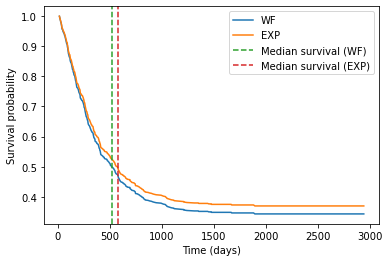

In [7]:
# Plot survival probability
class_wf = cph.predict_survival_function(df[df['class'] == 0]).mean(axis=1)
class_exp = cph.predict_survival_function(df[df['class'] == 1]).mean(axis=1)

# Plot survival probability
plt.plot(class_wf.index, class_wf.values, label='WF')
plt.plot(class_exp.index, class_exp.values, label='EXP')
plt.axvline(median_survival_times(class_wf), linestyle='--', color='tab:green', label='Median survival (WF)')
plt.axvline(median_survival_times(class_exp), linestyle='--', color='tab:red', label='Median survival (EXP)')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.legend()
plt.show()

In [24]:
# Hazard ratio
hr = cph.hazard_ratios_['class']
print('Hazard Ratio =',hr)
print('As it is significant and higher than 1, the predictor variable with higher value (EXP:1) has a higher risk of experiencing the event (death) than (WF:0)')

Hazard Ratio = 0.9307458682622545
As it is significant and higher than 1, the predictor variable with higher value (EXP:1) has a higher risk of experiencing the event (death) than (WF:0)
